In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import os, cmocean
import scipy.io as sio
from scipy import interpolate
from pyproj import Proj
import bathy_helpers
import bathy_readers
from matplotlib import path

from salishsea_tools import viz_tools, bathy_tools, nc_tools

ImportError: No module named 'bathy_helpers'

In [3]:
# Load bathy, and the t and f grid
#mfile = sio.loadmat('/ocean/mdunphy/MEOPAR/Bathy/Cascadi/../../bathy/hhh.mat')
#bathyjpi = mfile['h_wet2']  # JP's nearest interpolation (before removing lakes,etc)
#bathyjpi[np.isnan(bathyjpi)] = 0

bathyjp = bathy_readers.getnemo('../../bathy/bathy_meter_min4.nc', fillmissing=True)
bathyd1 = bathy_readers.getnemo('../../NEMO-forcing/grid/bathy_downonegrid2.nc', fillmissing=True)
bathy6  = bathy_readers.getnemo('../../NEMO-forcing/grid/bathy_meter_SalishSea6.nc', fillmissing=True)

cnc = nc.Dataset('../../NEMO-forcing/grid/coordinates_seagrid_SalishSea.nc', 'r')
glamf = cnc.variables['glamf'][0,...]; gphif = cnc.variables['gphif'][0,...]
glamt = cnc.variables['glamt'][0,...]; gphit = cnc.variables['gphit'][0,...]
cnc.close()
NY, NX = glamt.shape[0], glamt.shape[1]
glamfe, gphife = bathy_helpers.expandf(glamf, gphif)

NameError: name 'bathy_readers' is not defined

In [46]:
cascadiafile = '../../bathy/cascadia.bil'
cache = cascadiafile + ".results.npz"
if os.path.exists(cache):
    npzfile = np.load(cache)
    locals().update(npzfile)
else:
    # Work with Cascadia data
    x, y, z, p = bathy_readers.getcascadia(cascadiafile)

    # Convert NEMO coords to Cascadia projected coordinates
    Xt, Yt = p(glamt, gphit)
    Xf, Yf = p(glamf, gphif)
    Xfe, Yfe = p(glamfe, gphife)

    # There are too many points, so we filter based on minimum and maximum x,y
    idx1 = (x >= np.min(Xfe)) & (x <= np.max(Xfe))
    idx2 = (y >= np.min(Yfe)) & (y <= np.max(Yfe))
    x, y = x[idx1], y[idx2]
    z = z[idx2, :]
    z = z[:, idx1]
    X, Y = np.meshgrid(x, y, sparse=False, indexing='xy')
    X, Y, z = X.flatten(), Y.flatten(), z.flatten()

    # Further filter points not within the SalishSea domain
    poly0 = path.Path(bathy_helpers.makebox(Xfe, Yfe, 0, NX, 0, NY), closed=True)
    tmp = np.zeros([X.size, 2])
    tmp[:, 0] = X
    tmp[:, 1] = Y
    idx = poly0.contains_points(tmp)
    X, Y, z = X[idx], Y[idx], z[idx]

    # Construct new bathy using interpolation
    points = (X, Y)
    xi = (Xt.flatten(), Yt.flatten())
    casnearest = np.reshape(
        interpolate.griddata(
            points, z, xi, method='nearest'), Xt.shape)
    caslinear = np.reshape(
        interpolate.griddata(
            points, z, xi, method='linear'), Xt.shape)

    Xo, Yo = X - 125, Y - 125
    points = (Xo, Yo)
    casnearestjp = np.reshape(
        interpolate.griddata(
            points, z, xi, method='nearest'), Xt.shape)

    # Get the bin indices, apply bin methods
    boxi, boxj = bathy_helpers.getboxij(
        Xfe, Yfe, X, Y, cache=cascadiafile + ".boxij.npz", searchmore=False)
    casmin, casmax, casmean, casmedian, cascount = bathy_helpers.binstobathy(boxi, boxj, X,
                                                               Y, z, NX, NY)

    np.savez(
        cache,
        casmin=casmin,
        casmax=casmax,
        casmean=casmean,
        casmedian=casmedian,
        cascount=cascount,
        casnearest=casnearest,
        caslinear=caslinear,
        casnearestjp=casnearestjp)
#1239279 points in 407.3525502681732 s
#hit0 report: 466518/1239279=37.644307698266495%
#hit1 report: 768443/1239279=62.00726390102632%
#hit2 report: 0/1239279=0.0%
#hit3 report: 0/1239279=0.0%
#hit4 report: 0/1239279=0.0%
#no hit report: 4318/1239279=0.3484284007071854%
#points not in domain: 0

In [47]:
chsfile = '../../bathy/Salish Sea 25m Grid.txt'
cache = chsfile + ".results.npz"
if os.path.exists(cache):
    npzfile = np.load(cache)
    locals().update(npzfile)
else:
    # Work with CHS data
    x, y, z, p = bathy_readers.getchs(chsfile)

    # Convert NEMO coords to UTM Zone 10 coordinates
    Xt, Yt = p(glamt, gphit)
    Xf, Yf = p(glamf, gphif)
    Xfe, Yfe = p(glamfe, gphife)

    # Construct new bathy using interpolation
    points = (x, y)
    xi = (Xt.flatten(), Yt.flatten())
    chsnearest = np.reshape(
        interpolate.griddata(
            points, z, xi, method='nearest'), Xt.shape)
    chslinear = np.reshape(
        interpolate.griddata(
            points, z, xi, method='linear'), Xt.shape)

    # Get the bin indices, apply bin methods
    boxi, boxj = bathy_helpers.getboxij(
        Xfe, Yfe, x, y, cache=chsfile + ".boxij.npz", searchmore=True)
    chsmin, chsmax, chsmean, chsmedian, chscount = bathy_helpers.binstobathy(
        boxi, boxj, x, y, z, NX, NY)
    cache = chsfile + ".results.npz"
    np.savez(
        cache,
        chsmin=chsmin,
        chsmax=chsmax,
        chsmean=chsmean,
        chsmedian=chsmedian,
        chscount=chscount,
        chsnearest=chsnearest,
        chslinear=chslinear)

In [48]:
bc3file = '../../bathy/british_columbia_3sec.asc'
cache=bc3file+".results.npz"
if os.path.exists(cache):
    npzfile = np.load(cache)
    locals().update(npzfile)
else:
    # Work with BC3 data
    x,y,z,p = getbc3(bc3file)

    # There are too many points, so we filter based on minimum and maximum x,y
    idx1 = (x >= np.min(glamfe)) & (x <= np.max(glamfe))
    idx2 = (y >= np.min(gphife)) & (y <= np.max(gphife))
    x,y = x[idx1], y[idx2]
    z = z[idx2,:]
    z = z[:,idx1]
    X,Y = np.meshgrid(x, y, sparse=False, indexing='xy')
    X,Y,z = X.flatten(), Y.flatten(), z.flatten()

    # Further filter points not within the SalishSea domain
    poly0 = path.Path(makebox(glamfe,gphife,0,NX,0,NY), closed=True)
    tmp = np.zeros([X.size,2]); tmp[:,0]=X; tmp[:,1]=Y;
    idx = poly0.contains_points(tmp)
    X, Y, z = X[idx], Y[idx], z[idx]

    # Construct new bathy using interpolation
    points = (X,Y)
    xi = (glamt.flatten(), gphit.flatten())
    bc3nearest = np.reshape(interpolate.griddata(points, z, xi, method='nearest'), glamt.shape)
    bc3linear = np.reshape(interpolate.griddata(points, z, xi, method='linear'), glamt.shape)

    # Get the bin indices, apply bin methods
    boxi, boxj = getboxij(glamfe,gphife,X,Y,cache=bc3file+".boxij.npz",searchmore=False)
    bc3min,bc3max,bc3mean,bc3median,bc3count = binstobathy(boxi,boxj,X,Y,z,NX,NY)

    np.savez(cache, bc3min=bc3min, bc3max=bc3max, bc3mean=bc3mean, bc3median=bc3median,
                    bc3count=bc3count, bc3nearest=bc3nearest, bc3linear=bc3linear)
#10309989 points in 1063.4851875305176 s
#hit0 report: 8509929/10309989=82.54062152733626%
#hit1 report: 1790466/10309989=17.366323087250628%
#hit2 report: 0/10309989=0.0%
#hit3 report: 0/10309989=0.0%
#hit4 report: 0/10309989=0.0%
#no hit report: 9594/10309989=0.09305538541311732%
#points not in domain: 0

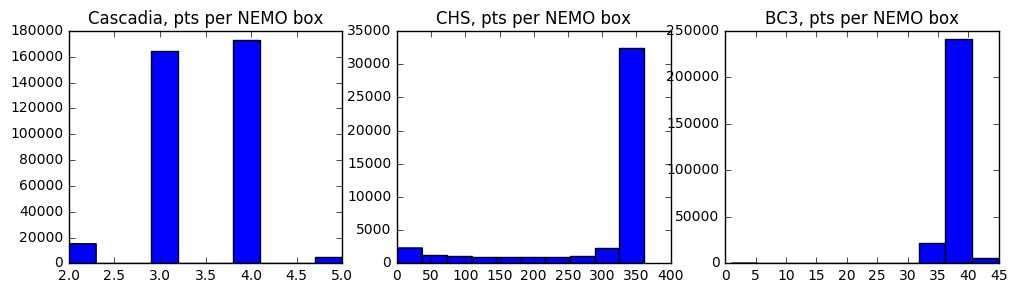

In [49]:
def dezero(x): return x.flatten()[x.flatten()>0]
plt.figure(figsize=(12,3)); plt.clf();
plt.subplot(1,3,1); plt.hist(dezero(cascount)); plt.title('Cascadia, pts per NEMO box')
plt.subplot(1,3,2); plt.hist(dezero(chscount)); plt.title('CHS, pts per NEMO box')
plt.subplot(1,3,3); plt.hist(dezero(bc3count)); plt.title('BC3, pts per NEMO box')

In [50]:
# Plotting helper funtions
def mm(x):
    return ma.masked_array(x, mask=(x == 0 | np.isnan(x)))


chsmask, casmask, b6mask, spmask = mm(chsmin), mm(casmin), mm(bathy6), mm(
    bathy6 + bathyjpi)


def cmp(a, b, c, d,
        e):  # compare a and b, mask from c, colorbar limits d, title e
    im = plt.pcolormesh(c * 0 + a - b)
    cb = plt.colorbar(im)
    im.set_cmap('seismic')
    im.set_clim([-d, d])
    cb.set_clim(-d, d)
    plt.title(e)


def shw(a, b, c, d):  # plot a, mask b, colorbar limits c, title d
    if b is None: b = mm(a)
    im = plt.pcolormesh(b * 0 + a)
    cb = plt.colorbar(im)
    im.set_cmap(cmocean.cm.haline)
    im.set_clim([0, c])
    cb.set_clim(0, c)
    plt.title(d)

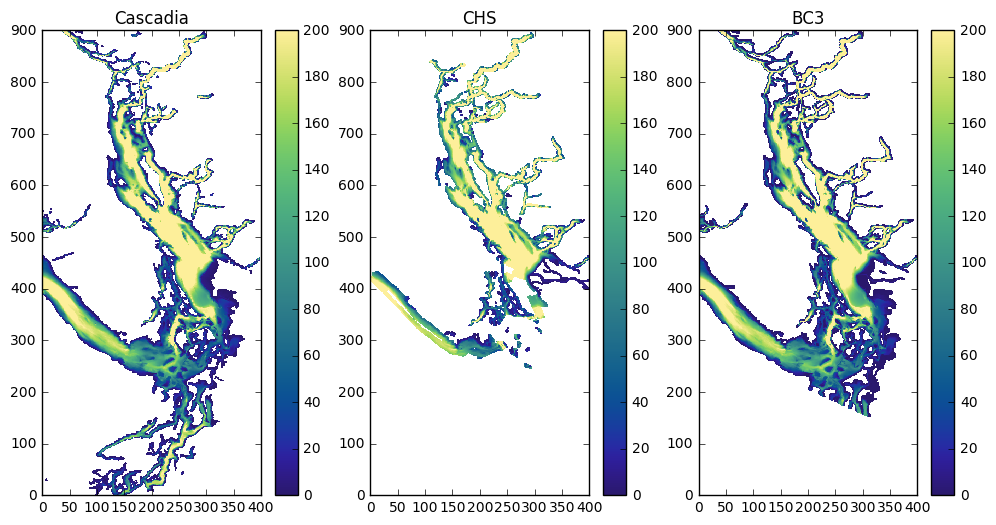

In [51]:
plt.figure(figsize=(12,6)); plt.clf();
plt.subplot(1,3,1); shw(casmean, None, 200, 'Cascadia')
plt.subplot(1,3,2); shw(chsmean, None, 200, 'CHS')
plt.subplot(1,3,3); shw(bc3mean, None, 200, 'BC3')


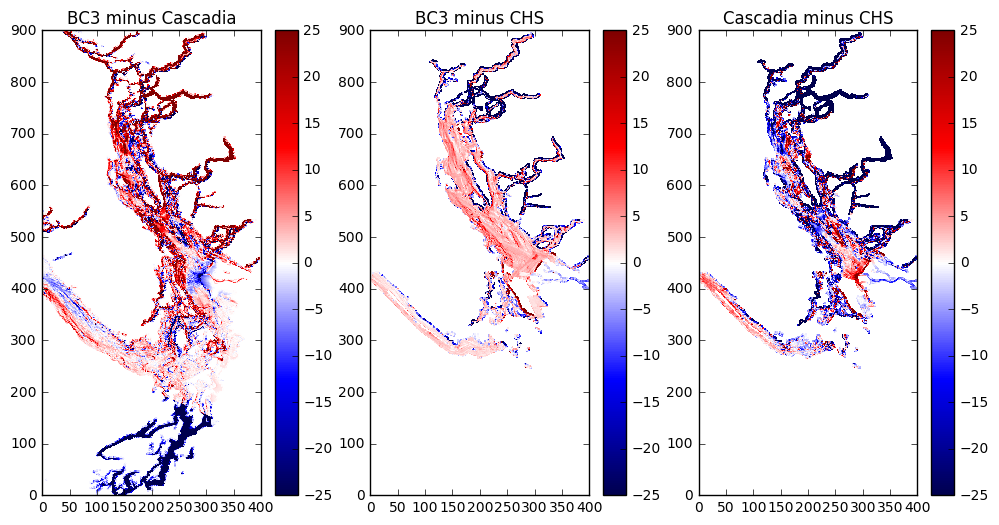

In [52]:
plt.figure(figsize=(12,6)); plt.clf();
plt.subplot(1,3,1); cmp(bc3mean, casmean, mm(casmean+bc3mean), 25, 'BC3 minus Cascadia')
plt.subplot(1,3,2); cmp(bc3mean, chsmean, mm(chsmean), 25, 'BC3 minus CHS')
plt.subplot(1,3,3); cmp(casmean, chsmean, mm(chsmean), 25, 'Cascadia minus CHS')


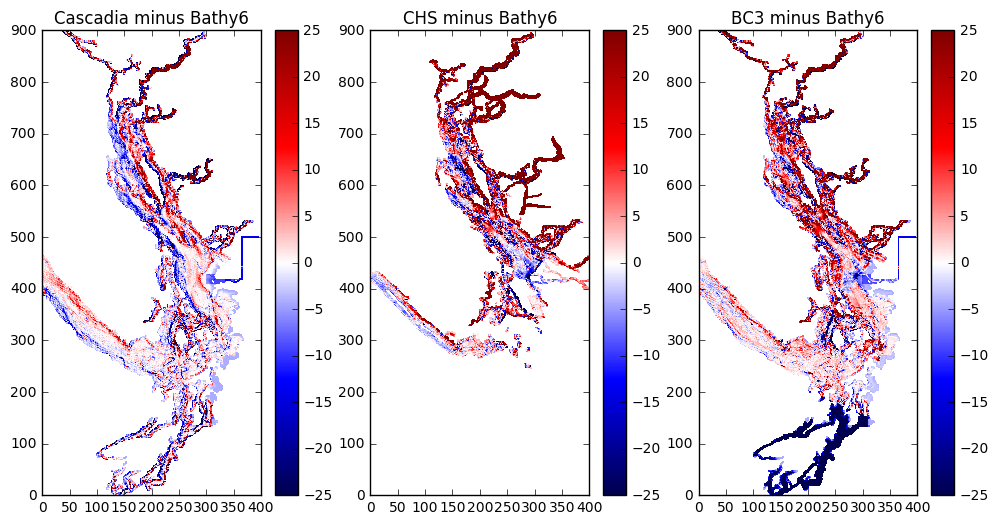

In [53]:
plt.figure(figsize=(12,6)); plt.clf();
plt.subplot(1,3,1); cmp(casmean, bathy6, mm(bathy6), 25, 'Cascadia minus Bathy6')
plt.subplot(1,3,2); cmp(chsmean, bathy6, mm(chsmean), 25, 'CHS minus Bathy6')
plt.subplot(1,3,3); cmp(bc3mean, bathy6, mm(bathy6), 25, 'BC3 minus Bathy6')


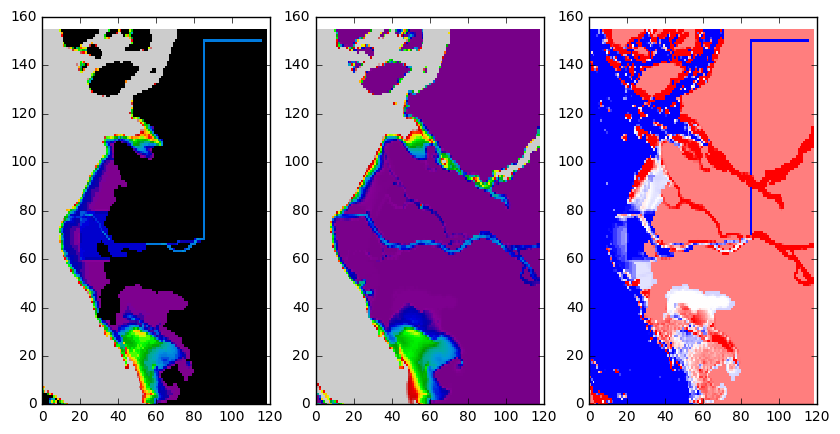

In [54]:
imin = 350; imax = 505; jmin = 280; jmax = 398
islice = slice(imin,imax); jslice = slice(jmin, jmax)
fig, axs = plt.subplots(1, 3, figsize=(10,5))
axs[0].pcolormesh(bathyd1[islice, jslice], cmap='spectral', vmax=55, vmin=0)
mybathy = np.maximum(bc3mean, chsmean) + 3
mesh = axs[1].pcolormesh(mybathy[islice, jslice], cmap='spectral', vmax=55, vmin=0)
axs[2].pcolormesh(mybathy[islice, jslice]-bathyd1[islice, jslice], cmap='bwr', vmax=6, vmin=-6)

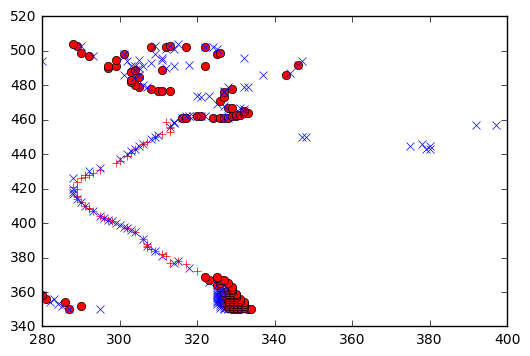

In [55]:
itop = 460; ibot = 370
depth1 = 55; depth2 = depth1 + 10
for i in range(imin, imax):
    for j in range(jmin, jmax):
        if bathyd1[i, j] > depth1 and bathyd1[i, j] < depth2:
            if i < itop and i > ibot:
                plt.plot(j, i, 'r+')
            else:
                plt.plot(j, i, 'ro')
        if mybathy[i, j] > depth1 and mybathy[i, j] < depth2:
            plt.plot(j, i, 'bx')

- between ibot and itop, for j> jmin,for mybathy < 55m, use mybathy
- two more things to do: cut off the harbour
- change the river

(410, 430)

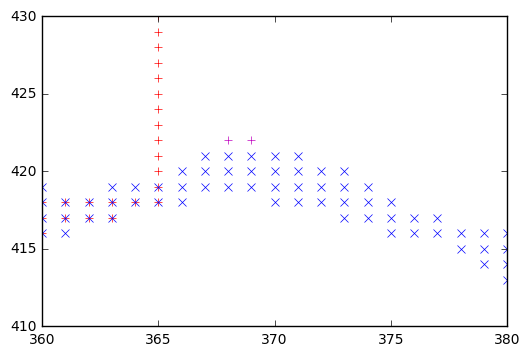

In [56]:
depth1 = 3.5; depth2 = depth1 + 20
for i in range(ibot, itop):
    for j in range(jmin, jmax):
        if bathyd1[i, j] > depth1 and bathyd1[i, j] < depth2:
            if i < itop and i > ibot:
                plt.plot(j, i, 'r+')
            else:
                plt.plot(j, i, 'ro')
        if mybathy[i, j] > depth1 and mybathy[i, j] < depth2:
            plt.plot(j, i, 'bx')
plt.plot((368, 369), (422, 422), 'm+')
plt.xlim((360, 380))
plt.ylim((410, 430))

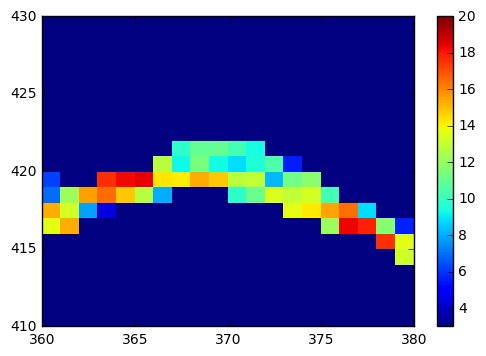

In [57]:
plt.pcolormesh(mybathy, vmax=20)
plt.xlim((360, 380))
plt.ylim((410, 430))
plt.colorbar()

So I want the river to head north 
- from (368, 369), 422 at a depth of 12 m with 2 grid points
- and not exist east of 369

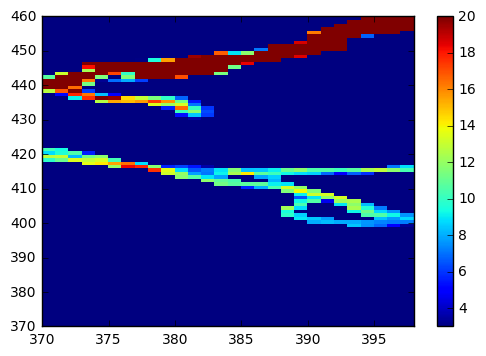

In [58]:
plt.pcolormesh(mybathy, vmax=20)
plt.xlim((370, 398))
plt.ylim((ibot, itop))
plt.colorbar()
jeast = 370

- okay, can wipe out mybathy east of jeast

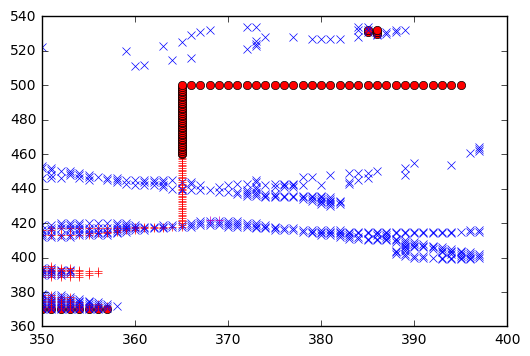

In [59]:
depth1 = 3.5; depth2 = depth1 + 20
for i in range(ibot, 550):
    for j in range(350, 398):
        if bathyd1[i, j] > depth1 and bathyd1[i, j] < depth2:
            if i < itop and i > ibot:
                plt.plot(j, i, 'r+')
            else:
                plt.plot(j, i, 'ro')
        if mybathy[i, j] > depth1 and mybathy[i, j] < depth2:
            plt.plot(j, i, 'bx')
plt.plot((368, 369), (422, 422), 'm+')

- river continues north to 500, then
- east to 395

358


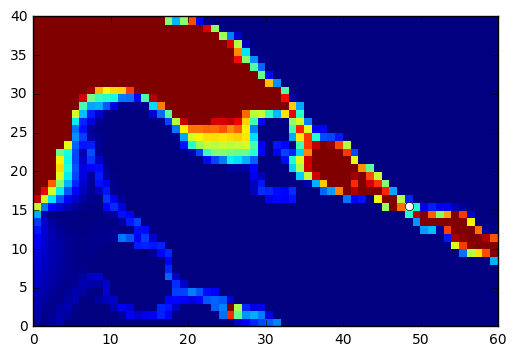

In [60]:
plt.pcolormesh(mybathy[430:470, jeast-60:jeast], vmax=25)
plt.plot(48+0.5, 15.5, 'wo')
SecNar = jeast-60+48
print (SecNar)

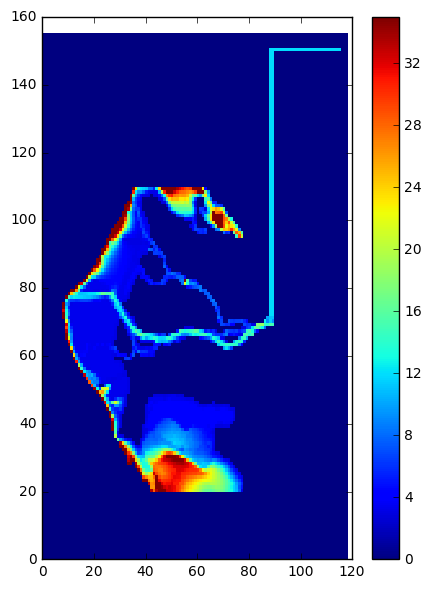

In [61]:
newbathy = np.zeros_like(mybathy)
for i in range(ibot, itop):
    for j in range(jmin, jmin + 60):
        if mybathy[i, j] < 55 and mybathy[i, j] > 3:
            newbathy[i, j] = mybathy[i, j]
    for j in range(jmin + 60, SecNar):
        if mybathy[i, j] > 3:
            newbathy[i, j] = mybathy[i, j]

for i in range(imin + 50, imin + 80):
    for j in range(SecNar, jeast):
        if mybathy[i, j] > 3:
            newbathy[i, j] = mybathy[i, j]

for j in [368, 369]:
    for i in range(422, 500):
        newbathy[i, j] = 12.

i = 500
for j in range(368, 396):
    newbathy[i, j] = 12

fig, ax = plt.subplots(1, 1, figsize=(5,7))
mesh = ax.pcolormesh(newbathy[islice, jslice], vmax=35)
fig.colorbar(mesh, ax=ax)

In [62]:
testbathy = np.copy(bathyd1)
for i in range(imin, imax):
    for j in range(jmin, jmax):
        if newbathy[i ,j] != 0:
            testbathy[i ,j] = newbathy[i, j]
j = 365
for i in range(420, 500):
    testbathy[i, j] = 0
i = 500
for j in range(365, 368):
    testbathy[i, j] = 0
for i in range(imin, imax):
    for j in range(jmin, jmax):
        if testbathy[i, j] != 0:
            testbathy[i, j] = max(4., testbathy[i, j])

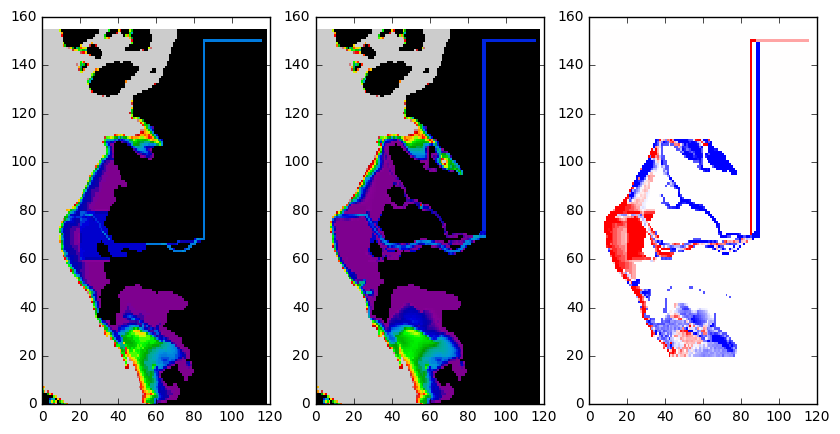

In [63]:
fig, axs = plt.subplots(1, 3, figsize=(10,5))
axs[0].pcolormesh(bathyd1[islice, jslice], cmap='spectral', vmax=55, vmin=0)
mesh = axs[1].pcolormesh(testbathy[islice, jslice], cmap='spectral', vmax=55, vmin=0)
axs[2].pcolormesh(bathyd1[islice, jslice]-testbathy[islice, jslice], cmap='bwr', vmax=6, vmin=-6)

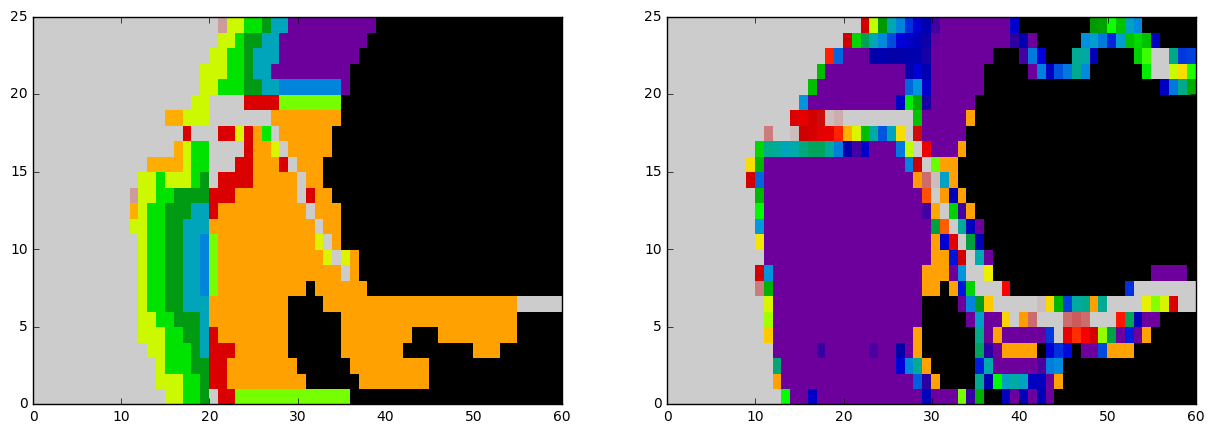

In [64]:
sislice = slice(imin+60, imin+85); sjslice = slice(jmin, jmin+60)
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].pcolormesh(bathyd1[sislice, sjslice], cmap='spectral', vmax=12, vmin=3)
mesh = axs[1].pcolormesh(testbathy[sislice, sjslice], cmap='spectral', vmax=12, vmin=3)

According to:
https://voony.files.wordpress.com/2012/10/gmtnauticalchart.jpg

it should be at least 13 m deep north of Deas.  So I'll make it continuous 12 m throughout.

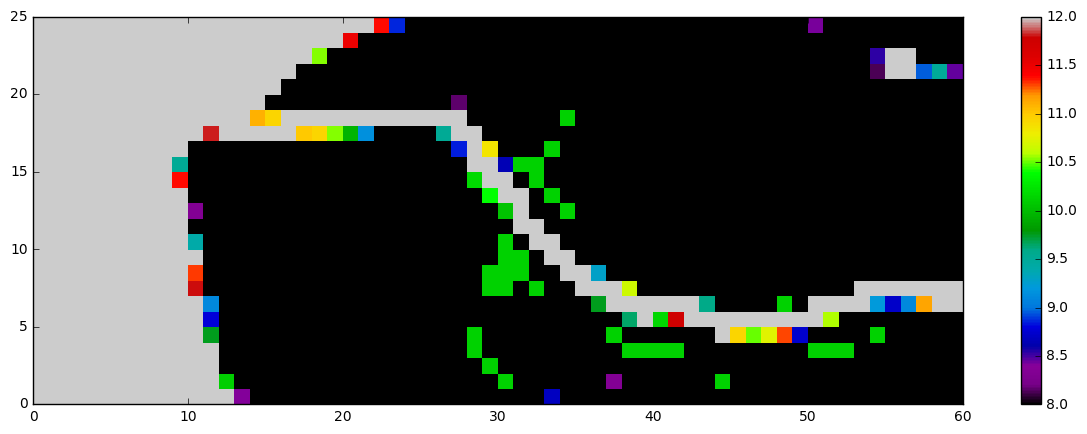

In [65]:
ibase = imin + 60
jbase = jmin + 15
testbathy[ibase + 5, jbase+30: jbase+33] = 12.
testbathy[ibase + 6, jbase+27] = 12.
testbathy[ibase + 9, jbase+18] = 12.
testbathy[ibase + 10, jbase+17] = 12.
testbathy[ibase + 11, jbase+16] = 12.
testbathy[ibase + 13, jbase+16] = 12.
testbathy[ibase + 14, jbase+15] = 12.
testbathy[ibase + 14, jbase+14] = 12.
testbathy[ibase + 15, jbase+13] = 12.
testbathy[ibase + 17, jbase+13] = 12.
testbathy[ibase + 18, jbase+1: jbase+5] = 12.
testbathy[ibase + 17, jbase-1: jbase+2] = 12.



fig, ax = plt.subplots(1, 1, figsize=(15, 5))
mesh = ax.pcolormesh(
    testbathy[sislice, sjslice], cmap='spectral', vmax=12, vmin=8)
fig.colorbar(mesh)

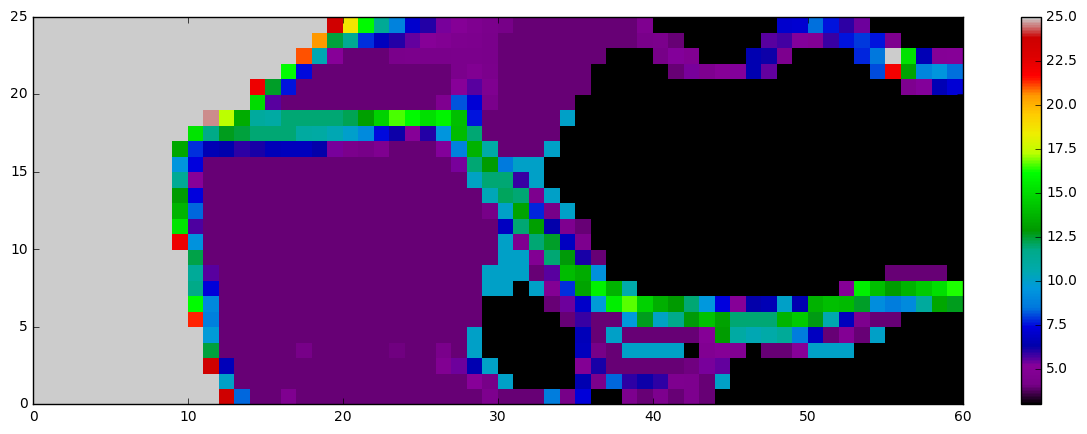

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
mesh = ax.pcolormesh(
    testbathy[sislice, sjslice], cmap='spectral', vmax=25, vmin=3)
fig.colorbar(mesh)

In [68]:
# lets smooth
max_dh_over_hbar = 0.8
depthsmooth = bathy_tools.smooth(testbathy[:], max_norm_depth_diff=max_dh_over_hbar, smooth_factor=0.2)

print (np.max(depthsmooth-testbathy))
print (np.min(depthsmooth-testbathy))

0.0
0.0


In [90]:
x = np.arange(295, 309); jv_x = np.arange(295, 309); ju_x = 308
y = np.ones(14)*428; jv_y = np.ones(14)*428; ju_y = 428
print (x.shape, y.shape)
x = np.append(x, (308, 309)); jv_x = np.append(jv_x, 309); ju_x = np.append(ju_x, 309)
y = np.append(y, (427, 427)); jv_y = np.append(jv_y, 427); ju_y = np.append(ju_y, 427)
x = np.append(x, (309, 310)); jv_x = np.append(jv_x, 310); ju_x = np.append(ju_x, 310)
y = np.append(y, (426, 426)); jv_y = np.append(jv_y, 426); ju_y = np.append(ju_y, 426)
x = np.append(x, (310, 311)); jv_x = np.append(jv_x, 311); ju_x = np.append(ju_x, 311)
y = np.append(y, (425, 425)); jv_y = np.append(jv_y, 425); ju_y = np.append(ju_y, 425)
x = np.append(x, (311, 312)); jv_x = np.append(jv_x, 312); ju_x = np.append(ju_x, 312)
y = np.append(y, (424, 424)); jv_y = np.append(jv_y, 424); ju_y = np.append(ju_y, 424)
print (x.shape, y.shape, ju_x.shape)

(14,) (14,)
(22,) (22,) (5,)


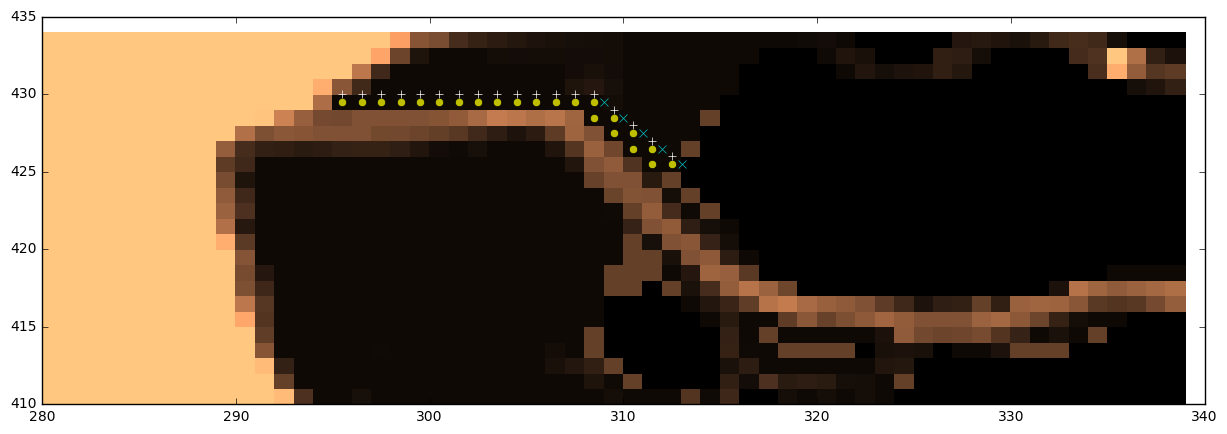

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
mesh = ax.pcolormesh(range(jmin, jmin+60), range(imin+60, imin+85),
                     depthsmooth[sislice, sjslice], cmap='copper', vmax=25, vmin=3)
for j,i in zip(y,x):
    ax.plot(i+0.5, j+1.5, 'oy')
for j,i in zip(jv_y, jv_x):
    ax.plot(i+0.5, j+2, '+w')
for j,i in zip(ju_y, ju_x):
    ax.plot(i+1, j+1.5, 'xc')

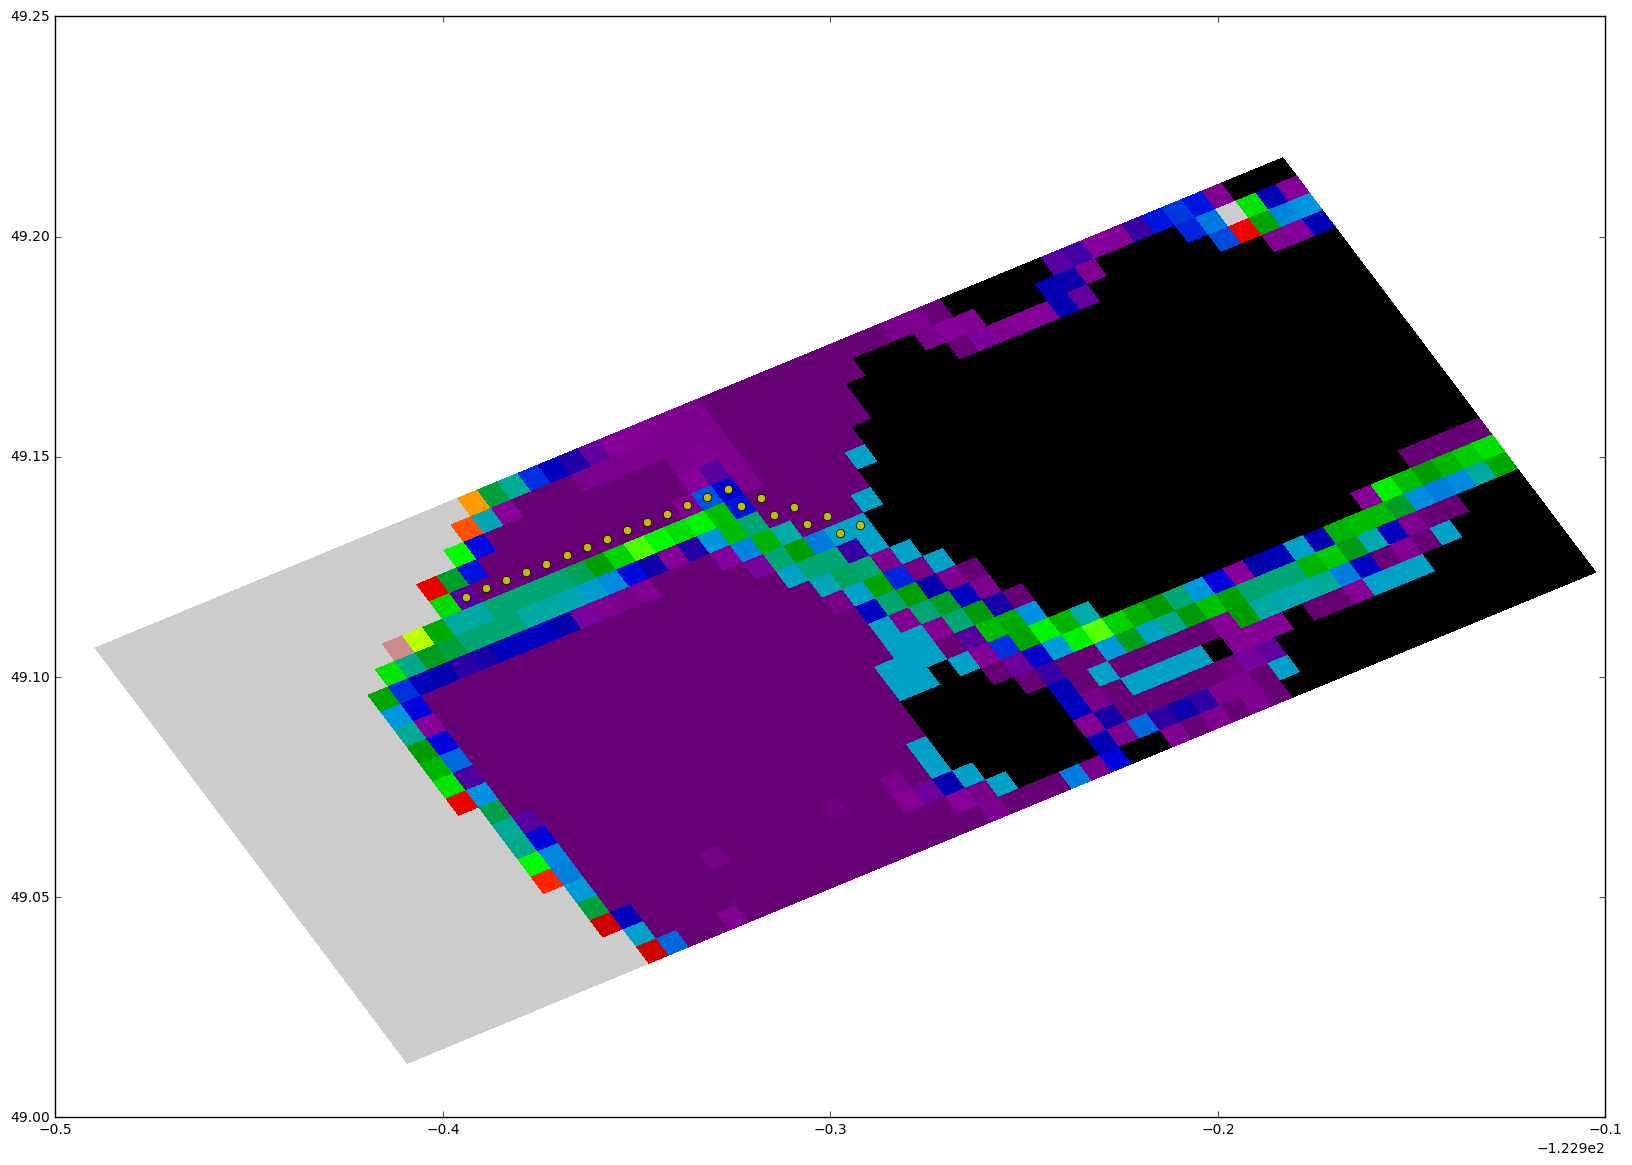

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(glamt[sislice, sjslice], gphit[sislice, sjslice],
    depthsmooth[sislice, sjslice], cmap='spectral', vmax=25, vmin=3)
for j,i in zip(y,x):
    ax.plot(glamf[int(j+1), int(i)], gphif[int(j+1), int(i)], 'oy')

/Users/sallen/anaconda/envs/hammer/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sallen/anaconda/envs/hammer/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


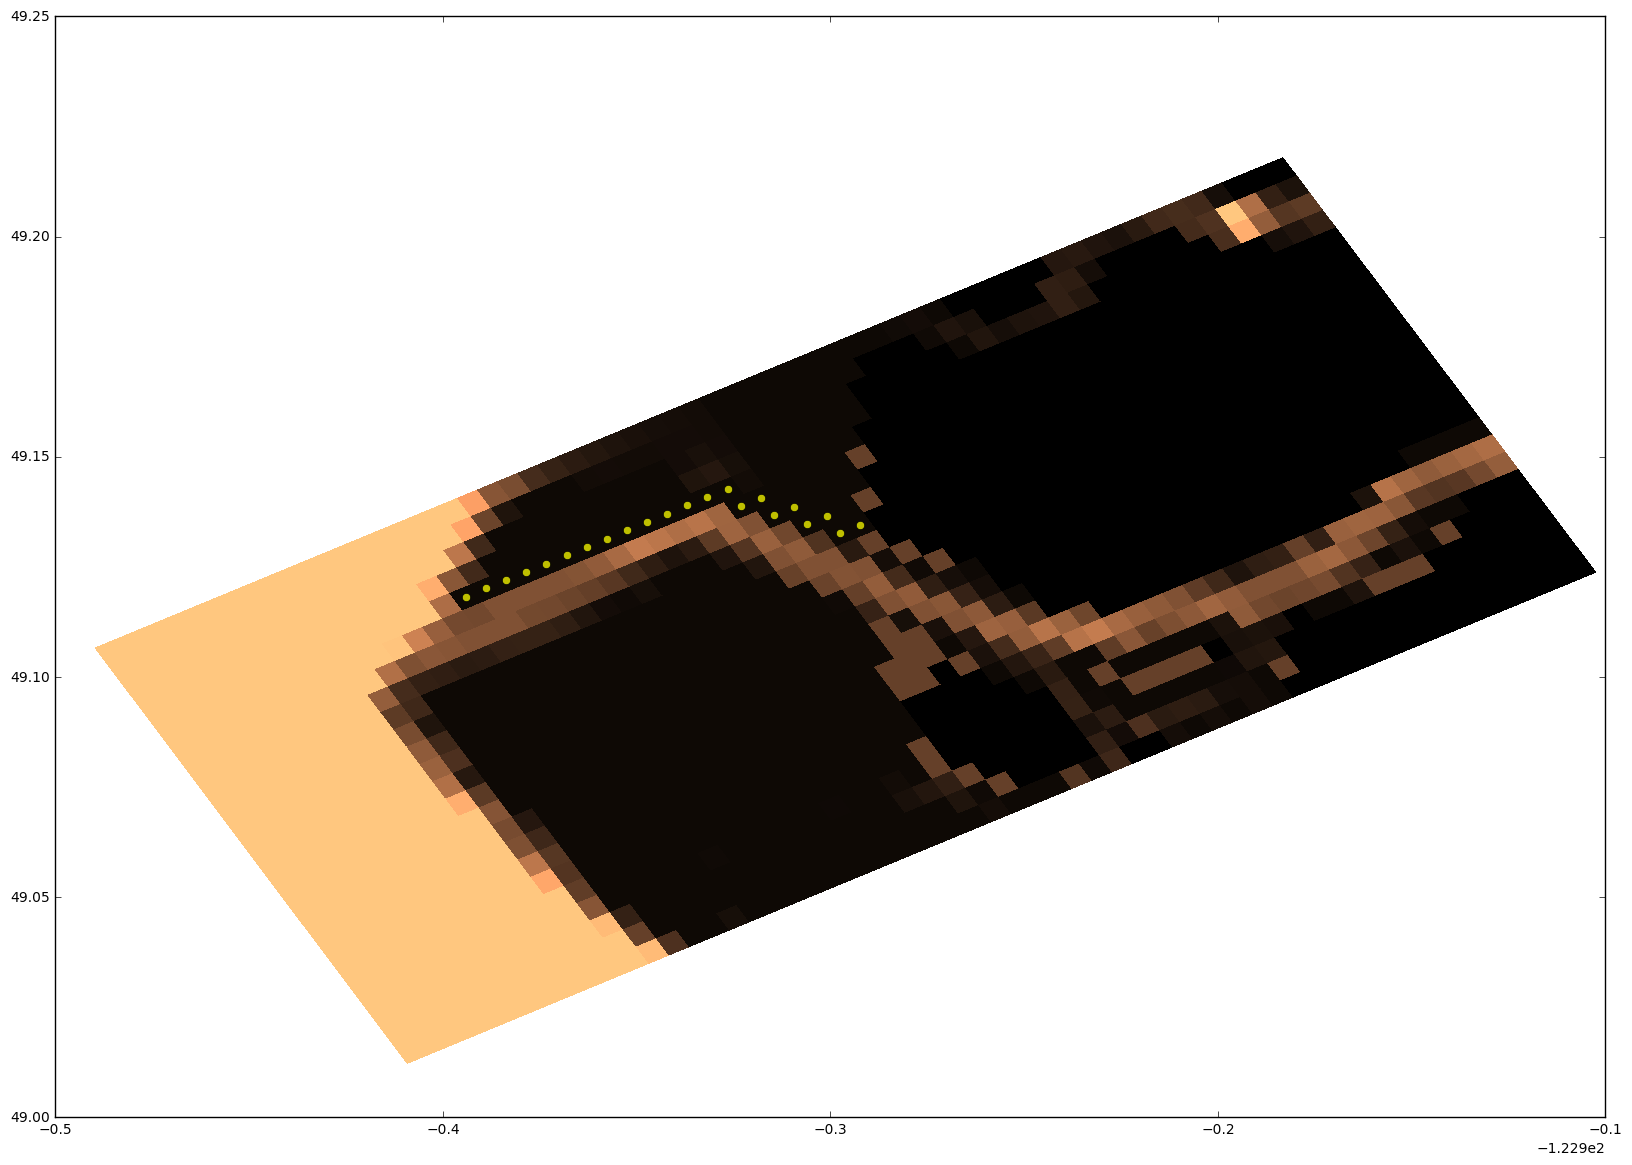

In [93]:
mask_for_jetty_u = np.zeros_like(testbathy)
mask_for_jetty_v = np.zeros_like(testbathy)
for i, j in zip(x, y):
    depthsmooth[j+1, i] = 4.0
for j, i in zip(jv_y, jv_x):
    mask_for_jetty_v[j+1, i]= 1.0
for j, i in zip(ju_y, ju_x):
    mask_for_jetty_u[j+1, i] = 1.0
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(glamt[sislice, sjslice], gphit[sislice, sjslice],
    depthsmooth[sislice, sjslice], cmap='copper', vmax=25, vmin=3)
for j,i in zip(y,x):
    ax.plot(glamf[int(j+1), int(i)], gphif[int(j+1), int(i)], 'oy')

In [95]:
#new_bathy.close()
dbyone = nc.Dataset('../../nemo-forcing/grid/bathy_downonegrid2.nc')

In [78]:
ysize = depthsmooth.shape[0]; xsize = depthsmooth.shape[1]
print (ysize, xsize)

new_bathy = nc.Dataset('./bathy_db1_jetty.nc', 'w')
new_bathy.createDimension('y', ysize)
new_bathy.createDimension('x', xsize)
nc_tools.show_dimensions(new_bathy)

898 398
<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 898

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 398



In [79]:
newlons = new_bathy.createVariable('nav_lon', float, ('y', 'x'), zlib=True)
newlons.setncattr('units', 'degrees_east')
newlats = new_bathy.createVariable('nav_lat', float, ('y', 'x'), zlib=True)
newlats.setncattr('units', 'degrees_north')
newdepths = new_bathy.createVariable(
    'Bathymetry', float, ('y', 'x'), 
    zlib=True, least_significant_digit=0.1, fill_value=0)
newdepths.setncattr('units', 'metres')

newlons[:] = dbyone.variables['nav_lon']
newlats[:] = dbyone.variables['nav_lat']
newdepths[:] = depthsmooth[:]

In [80]:
print (dbyone.history)


[2013-10-30 13:18] Created netCDF4 zlib=True dataset.
[2013-10-30 15:22] Set depths between 0 and 4m to 4m and those >428m to 428m.
[2013-10-31 17:10] Algorithmic smoothing.
[2013-11-21 19:53] Reverted to pre-smothing dataset (repo rev 3b301b5b9b6d).
[2013-11-21 20:14] Updated dataset and variable attributes to CF-1.6 conventions & project standards.
[2013-11-21 20:47] Removed east end of Jervis Inlet and Toba Inlet region due to deficient source bathymetry data in Cascadia dataset.
[2013-11-21 21:52] Algorithmic smoothing.
[2015-] Jie made Fraser River
[2015-12-24 11:46] dropped by one grid thickness, smoothed to 0.8
[2016-06-18 18:54] smoothed Juan de Fuca and Johnstone Strait mouths, checked smoothed to 0.8



In [81]:
new_bathy.history = """
[2013-10-30 13:18] Created netCDF4 zlib=True dataset.
[2013-10-30 15:22] Set depths between 0 and 4m to 4m and those >428m to 428m.
[2013-10-31 17:10] Algorithmic smoothing.
[2013-11-21 19:53] Reverted to pre-smothing dataset (repo rev 3b301b5b9b6d).
[2013-11-21 20:14] Updated dataset and variable attributes to CF-1.6 conventions & project standards.
[2013-11-21 20:47] Removed east end of Jervis Inlet and Toba Inlet region due to deficient source bathymetry data in Cascadia dataset.
[2013-11-21 21:52] Algorithmic smoothing.
[2014-01-01 14:44] Smoothed mouth of Juan de Fuca
[2015-] Jie made Fraser River
[2015-12-24 11:46] dropped by one grid thickness, smoothed to 0.8
[2016-12-25 12:09] replaced Fraser River area with deeper of BC3 and CHS, +3 m for datum, smoothed to 0.8. Deepened Fraser River channel. Added shallow jetty.
"""

In [82]:
new_bathy.conventions = """
CF-1.6"""

new_bathy.title= """
Salish Sea NEMO Bathymetry"""

new_bathy.institution= """ 
Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia"""

new_bathy.references= """ 
https://bitbucket.org/salishsea/nemo-forcing/src/tip/grid/bathy_db1_jetty.nc"""

new_bathy.comment= """
Based on 1_bathymetry_seagrid_WestCoast.nc file from 2-Oct-2013 WCSD_PREP tarball provided by J-P Paquin.
"""

new_bathy.source= """ 
https://bitbucket.org/salishsea/tools/src/tip/bathymetry/SalishSeaBathy.ipynb
https://bitbucket.org/salishsea/tools/src/tip/bathymetry/SmoothMouthJdF.ipynb
https://bitbucket.org/salishsea/tools/src/tip/bathymetry/Deepen by Grid Thickness.ipynb
https://bitbucket.org/salishsea/analysis-susan/src/tip/notebooks/bathymetry/Susan-newbathy.ipynb
"""

new_bathy.close()

In [83]:
dbyone.close()

In [102]:
ysize = depthsmooth.shape[0]; xsize = depthsmooth.shape[1]
print (ysize, xsize)

jetty_mask = nc.Dataset('./jetty_mask.nc', 'w')
jetty_mask.createDimension('y', ysize)
jetty_mask.createDimension('x', xsize)
nc_tools.show_dimensions(jetty_mask)

898 398
<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 898

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 398



In [103]:
newlons = jetty_mask.createVariable('nav_lon', float, ('y', 'x'), zlib=True)
newlons.setncattr('units', 'degrees_east')
newlats = jetty_mask.createVariable('nav_lat', float, ('y', 'x'), zlib=True)
newlats.setncattr('units', 'degrees_north')
friction_mask_u = jetty_mask.createVariable(
    'bfr_coef_u', float, ('y', 'x'), 
    zlib=True, least_significant_digit=0.01, fill_value=0)
friction_mask_u.setncattr('units', 'none')
friction_mask_v = jetty_mask.createVariable(
    'bfr_coef_v', float, ('y', 'x'), 
    zlib=True, least_significant_digit=0.01, fill_value=0)
friction_mask_v.setncattr('units', 'none')

In [104]:
newlons[:] = dbyone.variables['nav_lon']
newlats[:] = dbyone.variables['nav_lat']
friction_mask_u[:] = mask_for_jetty_u[:]
friction_mask_v[:] = mask_for_jetty_v[:]

In [105]:
jetty_mask.history = """
[2016-12-25 18:38] One over jetty, zero everywhere else, position based on max of CHS and BC3 bathymetry, u and v-direction bfr_coef_u bfr_coef_v separately
"""

jetty_mask.conventions = """
CF-1.6"""

jetty_mask.title= """
Mask to Enhance Friction over Jetties"""

jetty_mask.institution= """ 
Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia"""

jetty_mask.references= """ 
https://bitbucket.org/salishsea/nemo-forcing/src/tip/grid/jetty_mask.nc"""

jetty_mask.comment= """
One over Sandheads Jetty, zero elsewhere
"""

jetty_mask.source= """ 
https://bitbucket.org/salishsea/analysis-susan/src/tip/notebooks/bathymetry/Susan-newbathy.ipynb
"""

jetty_mask.close()

In [3]:
jetty = nc.Dataset('/ocean/sallen/allen/research/MEOPAR/nemo-forcing/grid/bathy_db1_jetty.nc')

In [4]:
bathy = jetty.variables['Bathymetry'][:]
lats = jetty.variables['nav_lat'][:]
lons = jetty.variables['nav_lon'][:]

In [5]:
jetty.close()

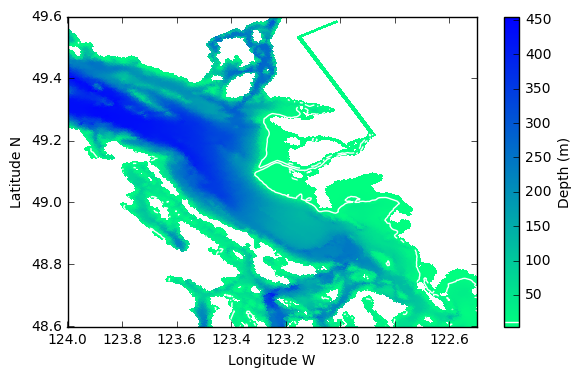

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))
mesh = ax.pcolormesh(-lons, lats, bathy, cmap='winter_r')
ax.set_xlim((124, 122.5))
#ax.invert_xaxis()
ax.set_ylim((48.6, 49.6))
ax.set_xlabel('Longitude W')
ax.set_ylabel('Latitude N')

cb = fig.colorbar(mesh, ax=ax)
cb.set_label('Depth (m)')

CS=ax.contour(-lons, lats, bathy,(0, 10), 
                  colors=('black', 'white'))
cb.add_lines(CS)


viz_tools.set_aspect(ax);